In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
fname = 'MiSeqRun1-FKS1-HS2_variant_data_merge.tsv' # FKS2-HS1 in MiSeqRun2, others in MiSeqRun1
strain = 'BY4741'
locus = 'FKS1-HS2'
pool_type = 'single'

min_input_readcount_high = 10
min_input_readcount_mid = 3

# Notebook to assess diversity from initial libraries sequenced in pre-runs

## Import libraries

In [2]:
import os
import glob
import re
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Functions

## Specify paths

In [3]:
metadata_path = '../data/'
variantdata_path = '../preruns/'
DMSdata_path = '../processed_data/'
codon_table_path = '../data/general_use/ScerevisiaeTAXID559292_Cocoputs_codon_table.csv'
graph_outpath = '../diagnostics_graphs/'

## Analysis

In [4]:
f = variantdata_path+fname

### Read dataframe

In [5]:
df = pd.read_csv(f, sep='\t', header=0, dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1_e1_s0_bNA_count,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagtgggtgagacgttatacacgt,KWVRRYTR,<NA>,False,False,5.0,2.0,2.0,1,1,True,False,True,True,False,False
1,aagtgggtgagacgttatacactg,KWVRRYTL,<NA>,False,False,3.0,1.0,2.0,1,1,True,False,True,True,False,False
2,aagtgggtgagacgttatacattg,KWVRRYTL,<NA>,False,False,2.0,1.0,1.0,197,197,True,False,True,True,False,False
3,aagtgggtgagacgttatatgttg,KWVRRYML,<NA>,False,False,4.0,2.0,2.0,1,1,True,False,True,True,False,False
4,aagtgggtgagacgttatcatttg,KWVRRYHL,<NA>,False,False,5.0,2.0,2.0,1,1,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,ttttgggtgggacgttatacattg,FWVGRYTL,<NA>,False,False,3.0,2.0,2.0,1,1,True,False,True,True,False,False
1209,ttttgggttagacgttatacattg,FWVRRYTL,<NA>,False,False,3.0,1.0,2.0,1,1,True,False,True,True,False,False
1210,ttttggttgagacgttatacattg,FWLRRYTL,<NA>,False,False,3.0,2.0,2.0,1,1,True,False,True,True,False,False
1211,ttttgtgtgagacgttatacattg,FCVRRYTL,<NA>,False,False,3.0,2.0,2.0,1,1,True,False,True,True,False,False


In [6]:
raw_cols = [x for x in df.columns if 'input' in x]
conditions = [x.split('_')[0] for x in raw_cols]
df.rename(columns=dict(zip(raw_cols, conditions)), inplace=True)
df.head(1)

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagtgggtgagacgttatacacgt,KWVRRYTR,<NA>,False,False,5.0,2.0,2.0,1,1,True,False,True,True,False,False


In [7]:
# Special case - FKS2-HS1 sequenced during MiSeqRun2 instead of MiSeqRun1
if locus == 'FKS2-HS1':
    p = re.compile(r'input[DO][1-6]')
    unwanted_cols = [x for x in df.columns if bool(p.fullmatch(x))]
    conditions = [x for x in conditions if x not in unwanted_cols]
    df.drop(unwanted_cols, axis=1, inplace=True)

In [8]:
# Extract WT sequences (nucleotide and protein)
wtseq = df.loc[df.WT==True, 'nt_seq'].values[0]
wtaa = df.loc[df.WT==True, 'aa_seq'].values[0]
print(f'WT (nt): {wtseq} | (aa): {wtaa}')

WT (nt): gattgggtgagacgttatacattg | (aa): DWVRRYTL


### Mean readcount per variant (raw data)

This matrix shows the average readcount per unique nucleotide sequence per number of mutated codons across samples.

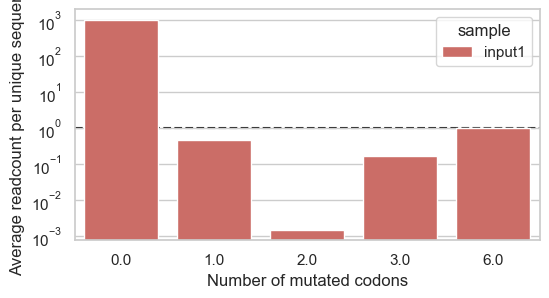

In [9]:
# Purge graph space
sns.set(rc = {'figure.figsize':(6,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

count_per_mut_codon = df.groupby('Nmut_codons')[conditions].count()
mean_rc_per_variant = df.groupby('Nmut_codons')[conditions].mean() / count_per_mut_codon
mean_rc_per_variant.reset_index(inplace=True)
mean_rc_long = mean_rc_per_variant.melt(id_vars=['Nmut_codons'], value_vars=conditions, var_name='sample')
sns.barplot(mean_rc_long, x='Nmut_codons',y='value',hue='sample',palette='hls')
plt.yscale('log')
plt.ylabel('Average readcount per unique sequence')
plt.xlabel('Number of mutated codons')
plt.axhline(y=1, linestyle='--', c='k', zorder=-10)

### Overrepresented variants (raw data)

The table below shows the 5 most represented sequences (mean readcount across samples) in % read depth per sample.

In [10]:
overrep_index = df[conditions].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,nt_seq,aa_seq,Nmut_codons
595,2.78,gattgggtgagacgttatacattg,DWVRRYTL,0.0
843,0.87,gattgggtgttgcgttatacattg,DWVLRYTL,1.0
820,0.85,gattgggtgtagcgttatacattg,DWV*RYTL,1.0
665,0.82,gattgggtgagacgtttgacattg,DWVRRLTL,1.0
994,0.79,gatttggtgagacgttatacattg,DLVRRYTL,1.0


### Calculate % read depth per sample corresponding to variants with no indels + read count above threshold

In [11]:
# Sum all reads for each sample
# Check proportion that corresponds to variants with no indels
rcNoIndel = df[conditions].sum(axis=0).to_frame('Total_reads')
rcNoIndel['Reads_no_indels'] = df[df.indel == False][conditions].sum(axis=0)
rcNoIndel['Reads_no_indels_%'] = 100*round(rcNoIndel['Reads_no_indels']/rcNoIndel['Total_reads'], 3)

# Check proportion that corresponds to variants with a read count >= 3 in any sample
rcNoIndel['No_indels_acceptable_RC'] = df[((df[conditions] > 2).any(axis=1)) & (df.indel == False)][conditions].sum(axis=0)
rcNoIndel['Acceptable_RC_over_no_indels_%'] = 100*round(rcNoIndel['No_indels_acceptable_RC']/rcNoIndel['Reads_no_indels'], 3)

rcNoIndel

,Total_reads,Reads_no_indels,Reads_no_indels_%,No_indels_acceptable_RC,Acceptable_RC_over_no_indels_%
input1,36018,35813,99.4,35016,97.8


#### ⚠️ **Filtering step** ⚠️ - Discard variants with indels

In [12]:
# Keeping only variants with no indels
df.drop(df[df.indel].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagtgggtgagacgttatacacgt,KWVRRYTR,<NA>,False,False,5.0,2.0,2.0,1,1,True,False,True,True,False,False
1,aagtgggtgagacgttatacactg,KWVRRYTL,<NA>,False,False,3.0,1.0,2.0,1,1,True,False,True,True,False,False
2,aagtgggtgagacgttatacattg,KWVRRYTL,<NA>,False,False,2.0,1.0,1.0,197,197,True,False,True,True,False,False
3,aagtgggtgagacgttatatgttg,KWVRRYML,<NA>,False,False,4.0,2.0,2.0,1,1,True,False,True,True,False,False
4,aagtgggtgagacgttatcatttg,KWVRRYHL,<NA>,False,False,5.0,2.0,2.0,1,1,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,ttttgggtgatacgttatacattg,FWVIRYTL,<NA>,False,False,3.0,2.0,2.0,1,1,True,False,True,True,False,False
1009,ttttgggtgggacgttatacattg,FWVGRYTL,<NA>,False,False,3.0,2.0,2.0,1,1,True,False,True,True,False,False
1010,ttttgggttagacgttatacattg,FWVRRYTL,<NA>,False,False,3.0,1.0,2.0,1,1,True,False,True,True,False,False
1011,ttttggttgagacgttatacattg,FWLRRYTL,<NA>,False,False,3.0,2.0,2.0,1,1,True,False,True,True,False,False


#### ⚠️ **Filtering step** ⚠️ - Keep only variants with at least 3 reads in at least 1 input replicate

In [13]:
inputRCdf = df[(df[conditions] > 2).any(axis=1)].reset_index(drop=True)
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagtgggtgagacgttatacattg,KWVRRYTL,<NA>,False,False,2.0,1.0,1.0,197,197,True,False,True,True,False,False
1,aagttggtgagacgttatacattg,KLVRRYTL,<NA>,False,False,3.0,2.0,2.0,3,3,True,False,True,True,False,False
2,aattgggtgagacgttatacattg,NWVRRYTL,<NA>,False,False,1.0,1.0,1.0,149,149,True,False,True,True,False,False
3,acgtgggtgagacgttatacattg,TWVRRYTL,<NA>,False,False,3.0,1.0,1.0,147,147,True,False,True,True,False,False
4,acttgggtgagacgttatacattg,TWVRRYTL,<NA>,False,False,2.0,1.0,1.0,148,148,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,tcttgggtgagacgttatacattg,SWVRRYTL,<NA>,False,False,2.0,1.0,1.0,170,170,True,False,True,True,False,False
250,tggtgggtgagacgttatacattg,WWVRRYTL,<NA>,False,False,3.0,1.0,1.0,126,126,True,False,True,True,False,False
251,tgttgggtgagacgttatacattg,CWVRRYTL,<NA>,False,False,2.0,1.0,1.0,135,135,True,False,True,True,False,False
252,ttgtgggtgagacgttatacattg,LWVRRYTL,<NA>,False,False,3.0,1.0,1.0,258,258,True,False,True,True,False,False


### Label variants with confidence score (related to readcount)

In [14]:
def get_confidence_score(g, thresh_high, thresh_mid):
    # The read count in all input replicates is parsed to label each variant with a confidence score
    # Score is an integer for easy aggregation of synonymous codons
    if (g >= thresh_high).all():
        return 1 # high confidence score
    elif (g > thresh_mid).any():
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [15]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
inputRCdf['confidence_score'] = inputRCdf[conditions].apply(lambda row: get_confidence_score(row, min_input_readcount_high, min_input_readcount_mid), axis=1)
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,input1,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score
0,aagtgggtgagacgttatacattg,KWVRRYTL,<NA>,False,False,2.0,1.0,1.0,197,197,True,False,True,True,False,False,1
1,aagttggtgagacgttatacattg,KLVRRYTL,<NA>,False,False,3.0,2.0,2.0,3,3,True,False,True,True,False,False,3
2,aattgggtgagacgttatacattg,NWVRRYTL,<NA>,False,False,1.0,1.0,1.0,149,149,True,False,True,True,False,False,1
3,acgtgggtgagacgttatacattg,TWVRRYTL,<NA>,False,False,3.0,1.0,1.0,147,147,True,False,True,True,False,False,1
4,acttgggtgagacgttatacattg,TWVRRYTL,<NA>,False,False,2.0,1.0,1.0,148,148,True,False,True,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,tcttgggtgagacgttatacattg,SWVRRYTL,<NA>,False,False,2.0,1.0,1.0,170,170,True,False,True,True,False,False,1
250,tggtgggtgagacgttatacattg,WWVRRYTL,<NA>,False,False,3.0,1.0,1.0,126,126,True,False,True,True,False,False,1
251,tgttgggtgagacgttatacattg,CWVRRYTL,<NA>,False,False,2.0,1.0,1.0,135,135,True,False,True,True,False,False,1
252,ttgtgggtgagacgttatacattg,LWVRRYTL,<NA>,False,False,3.0,1.0,1.0,258,258,True,False,True,True,False,False,1


### Merge with dataframe of expected variants

In [16]:
# Dataframe containing all expected mutants for the different libraries (single, double, ortholog) is imported
# /!\ Important to note that I did not actually separate by type of library /!\
# "Double" mutants do not include single mutants
# "Ortho" are standalone (double mutants in orthologous sequences are duplicated in "double" and "ortho" seq types)
source = metadata_path+locus+f'/{locus}_var_df.csv'
vardf = pd.read_csv(source, header=0, index_col=0)
vardf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination
0,WT,gattgggtgagacgttatacattg,NaN,NaN,NaN,NaN
1,single,ttttgggtgagacgttatacattg,0.0,ttt,1.0,NaN
2,single,ttgtgggtgagacgttatacattg,0.0,ttg,1.0,NaN
3,single,ctttgggtgagacgttatacattg,0.0,ctt,1.0,NaN
4,single,ctgtgggtgagacgttatacattg,0.0,ctg,1.0,NaN
...,...,...,...,...,...,...
55498,ortho,gattggatttatagatctattttg,2.0,att,1.0,NaN
55499,ortho,gattggatttatagatctattttg,3.0,tat,2.0,NaN
55500,ortho,gattggatttatagatctattttg,4.0,aga,3.0,NaN
55501,ortho,gattggatttatagatctattttg,5.0,tct,4.0,NaN


#### ⚠️ **Filtering step** ⚠️ - Keep only mutants corresponding to pool_type

In [17]:
# Depending on the type of pool (single or double), expected variants are filtered
# The dictionary specifies which sequence types must be kept
keep_seq_type = {'single' : ['WT', 'single'#, 'ortho'
                            ]#,
                 #'double': ['WT', 'single', 'double']
                }

var_filtered_df = vardf[vardf.seq_type.isin(keep_seq_type[pool_type])]
len(var_filtered_df)

251

In [18]:
# Here we need to translate expected variants to aa,.. which will also us to count the expected number of unique aa variants
# I did not do this in the first place because I didn't need it to merge with the dataframe of variant counts
codon_table = pd.read_csv(codon_table_path, header=0)
codon_table['codon'] = codon_table['codon'].str.lower()
codon_dic = dict(zip(codon_table['codon'], codon_table['aminoacid']))
def get_aa_seq(seq, cdic):
    clist = [seq[i:i+3] for i in range(0, len(seq), 3)] # Converting nucleotide sequence to list of codons
    return ''.join([cdic[x] for x in clist])

In [19]:
var_filtered_df['aa_seq'] = var_filtered_df.nt_seq.apply(lambda x: get_aa_seq(x, codon_dic))
var_filtered_df

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq
0,WT,gattgggtgagacgttatacattg,NaN,NaN,NaN,NaN,DWVRRYTL
1,single,ttttgggtgagacgttatacattg,0.0,ttt,1.0,NaN,FWVRRYTL
2,single,ttgtgggtgagacgttatacattg,0.0,ttg,1.0,NaN,LWVRRYTL
3,single,ctttgggtgagacgttatacattg,0.0,ctt,1.0,NaN,LWVRRYTL
4,single,ctgtgggtgagacgttatacattg,0.0,ctg,1.0,NaN,LWVRRYTL
...,...,...,...,...,...,...,...
246,single,gattgggtgagacgttatacacgg,7.0,cgg,1.0,NaN,DWVRRYTR
247,single,gattgggtgagacgttatacaagt,7.0,agt,1.0,NaN,DWVRRYTS
248,single,gattgggtgagacgttatacaagg,7.0,agg,1.0,NaN,DWVRRYTR
249,single,gattgggtgagacgttatacaggt,7.0,ggt,1.0,NaN,DWVRRYTG


In [20]:
len(var_filtered_df.nt_seq.unique())

251

In [21]:
unique_aa = len(var_filtered_df.aa_seq.unique())
unique_aa

161

In [22]:
# The dataframe of sequenced variants ( with no indels and readcount > threshold in all input replicates) and the dataframe of expected mutants are compared
# The column 'Location' indicates if a variant is found only in the set of expected variants (left), only in the sequenced dataset (right), or in both (covered variants)

comparedf = pd.merge(left=var_filtered_df.drop(columns='aa_seq'), right=inputRCdf, how='outer', on='nt_seq', indicator='Location')
comparedf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input1,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
0,WT,gattgggtgagacgttatacattg,NaN,NaN,NaN,NaN,DWVRRYTL,True,False,False,...,1003,1003,True,False,True,True,False,False,1,both
1,single,ttttgggtgagacgttatacattg,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,256,256,True,False,True,True,False,False,1,both
2,single,ttgtgggtgagacgttatacattg,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,258,258,True,False,True,True,False,False,1,both
3,single,ctttgggtgagacgttatacattg,0.0,ctt,1.0,NaN,LWVRRYTL,<NA>,False,False,...,164,164,True,False,True,True,False,False,1,both
4,single,ctgtgggtgagacgttatacattg,0.0,ctg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,162,162,True,False,True,True,False,False,1,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,single,gattgggtgagacgttatacaggt,7.0,ggt,1.0,NaN,DWVRRYTG,<NA>,False,False,...,73,73,True,False,True,True,False,False,1,both
250,single,gattgggtgagacgttatacaggg,7.0,ggg,1.0,NaN,DWVRRYTG,<NA>,False,False,...,86,86,True,False,True,True,False,False,1,both
251,NaN,aagttggtgagacgttatacattg,NaN,NaN,NaN,NaN,KLVRRYTL,<NA>,False,False,...,3,3,True,False,True,True,False,False,3,right_only
252,NaN,gattggttgagacgttataggttg,NaN,NaN,NaN,NaN,DWLRRYRL,<NA>,False,False,...,3,3,True,False,True,True,False,False,3,right_only


In [23]:
# From that we build a summary with number of variants and read counts across samples
# Careful, some variants and their associated reads are shared among different samples
seqdf = inputRCdf[conditions].astype(bool).sum(axis=0).to_frame('Filtered_sequenced_variants') # No duplicates in this dataframe - corresponds to sequenced variants (expected AND unexpected)
seqdf['Filtered_sequenced_variants_rc'] = inputRCdf[conditions].sum(axis=0)
seqdf['Usable_variants'] = comparedf[comparedf.Location.str.contains('both')].groupby(['aa_seq','nt_seq'])[conditions].first().astype(bool).sum(axis=0)
seqdf['AA'] = comparedf[comparedf.Location.str.contains('both')].groupby(['aa_seq','nt_seq'])[conditions].first().groupby('aa_seq')[conditions].sum().astype(bool).sum(axis=0)
# Below we calculate how many variants (of the proper seq type) are found in our sequencing dataset after filtering steps
# Only the highest percentage value is relevant, since variants are shared between input and output samples (some of them being depleted after selection)
# Expected but unsequenced variants might have been absent from our initial libraries of mutants
seqdf['Covered_variants_%'] = 100*round(seqdf['Usable_variants']/len(var_filtered_df.nt_seq.unique()),3)
seqdf['AA_%'] = 100*round(seqdf['AA']/unique_aa,3)
seqdf['Usable_variants_rc'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().sum(axis=0)
seqdf['Usable_variants_%rc'] = 100*round(seqdf['Usable_variants_rc']/seqdf['Filtered_sequenced_variants_rc'],3)
seqdf['Unsequenced_variants'] = comparedf[comparedf.Location.str.contains('left')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Readcount for unsequenced variants is by definition = 0
seqdf['Unexpected_variants'] = comparedf[comparedf.Location.str.contains('right')][conditions].astype(bool).sum(axis=0)
seqdf['Unexpected_variants_rc'] = comparedf[comparedf.Location.str.contains('right')][conditions].sum(axis=0)
# %Readcount for unexpected variants is always 100 - %rc for covered variants

seqdf

,Filtered_sequenced_variants,Filtered_sequenced_variants_rc,Usable_variants,AA,Covered_variants_%,AA_%,Usable_variants_rc,Usable_variants_%rc,Unsequenced_variants,Unexpected_variants,Unexpected_variants_rc
input1,254,35016,251,161,100.0,100.0,35007,100.0,0,3,9


### Read counts on **sequenced** variants

#### ⚠️ **Filtering step** ⚠️ - Keep only expected variants

In [24]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf = comparedf[comparedf.Location.str.contains('both')].reset_index(drop=True)
covereddf[covereddf.duplicated(subset='nt_seq', keep=False)].head(5)

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input1,output1_e1_s1_b1_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location


In [25]:
totrc = covereddf.groupby('nt_seq')[conditions].first().sum(axis=0).to_frame('total_readcount')
totrc['WT'] = covereddf[covereddf.Nham_aa == 0].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['WT_%'] = 100*round(totrc['WT'] / totrc['total_readcount'], 3)
totrc['NhamAA1_rc'] = covereddf[covereddf.Nham_aa == 1].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['NhamAA1_rc_%'] = 100*round(totrc['NhamAA1_rc'] / totrc['total_readcount'], 3)
totrc['NhamAA2_rc'] = covereddf[covereddf.Nham_aa == 2].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['NhamAA2_rc_%'] = 100*round(totrc['NhamAA2_rc'] / totrc['total_readcount'], 3)
totrc['NhamAA3+_rc'] = covereddf[covereddf.Nham_aa > 2].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['NhamAA3+_rc_%'] = 100*round(totrc['NhamAA3+_rc'] / totrc['total_readcount'], 3)
        
totrc

,total_readcount,WT,WT_%,NhamAA1_rc,NhamAA1_rc_%,NhamAA2_rc,NhamAA2_rc_%,NhamAA3+_rc,NhamAA3+_rc_%
input1,35007,2161,6.2,32846,93.8,0,0.0,0,0.0


### Average read frequency

In [26]:
cov_upset = covereddf.groupby(['aa_seq','nt_seq']).agg(dict(zip(conditions+['Nham_aa', 'confidence_score'], ['first']*(len(conditions)+2))))
aggdic = dict(zip(conditions, ['median']*len(conditions)))
aggdic['Nham_aa'] = 'first'
aggdic['confidence_score'] = 'min'
aa_upset = cov_upset.groupby('aa_seq').agg(aggdic)

In [27]:
samples = conditions
pool_df = aa_upset.reset_index()[['aa_seq','Nham_aa','confidence_score']+samples]
pool_df[samples] = pool_df[samples].div(pool_df[samples].sum(axis=0), axis=1)
pool_df['average_freq_pool'] = pool_df[samples].mean(axis=1)
pool_df

,aa_seq,Nham_aa,confidence_score,input1,average_freq_pool
0,*WVRRYTL,1.0,1,0.010655,0.010655
1,AWVRRYTL,1.0,1,0.002830,0.002830
2,CWVRRYTL,1.0,1,0.005969,0.005969
3,D*VRRYTL,1.0,1,0.011804,0.011804
4,DAVRRYTL,1.0,1,0.004421,0.004421
...,...,...,...,...,...
156,SWVRRYTL,1.0,1,0.007516,0.007516
157,TWVRRYTL,1.0,1,0.006521,0.006521
158,VWVRRYTL,1.0,1,0.004974,0.004974
159,WWVRRYTL,1.0,1,0.005571,0.005571


### Compare with input in DMS experiment

In [28]:
DMSf = f'{DMSdata_path}{strain}_{locus}_single_ortho_none/selcoeff_all_libraries.csv'

In [29]:
DMSdf = pd.read_csv(DMSf, header=0, index_col=0,
                    dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
DMSdf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b3_log10,alt_aa,mutation_type,Log2FC_1,Log2FC_2,Log2FC_3,selcoeff_1,selcoeff_2,selcoeff_3,median_s
0,single,ttttgggtgagacgttatacattg,0.0,ttt,1.0,NaN,FWVRRYTL,<NA>,False,False,...,-1.854191,F,non-synonymous,-0.071871,-0.095830,-0.091700,0.017002,0.152116,0.171600,0.152116
1,single,ttgtgggtgagacgttatacattg,0.0,ttg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-2.708009,L,non-synonymous,-0.113504,-0.183024,-0.147477,-0.024631,0.064923,0.115823,0.064923
2,single,ctttgggtgagacgttatacattg,0.0,ctt,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-2.958482,L,non-synonymous,-0.057853,-0.136193,-0.068939,0.031020,0.111754,0.194362,0.111754
3,single,ctgtgggtgagacgttatacattg,0.0,ctg,1.0,NaN,LWVRRYTL,<NA>,False,False,...,-2.592214,L,non-synonymous,-0.024083,-0.115885,-0.102083,0.064790,0.132062,0.161218,0.132062
4,single,atttgggtgagacgttatacattg,0.0,att,1.0,NaN,IWVRRYTL,<NA>,False,False,...,-2.679478,I,non-synonymous,-0.059975,-0.127113,-0.143584,0.028898,0.120834,0.119717,0.119717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,WT,gattgggtgagacgttatacattg,3.0,aga,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,R,synonymous,-0.111276,-0.027630,-0.157724,-0.022403,0.220317,0.105577,0.105577
551,WT,gattgggtgagacgttatacattg,4.0,cgt,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,R,synonymous,-0.111276,-0.027630,-0.157724,-0.022403,0.220317,0.105577,0.105577
552,WT,gattgggtgagacgttatacattg,5.0,tat,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,Y,synonymous,-0.111276,-0.027630,-0.157724,-0.022403,0.220317,0.105577,0.105577
553,WT,gattgggtgagacgttatacattg,6.0,aca,NaN,NaN,DWVRRYTL,True,NaN,NaN,...,NaN,T,synonymous,-0.111276,-0.027630,-0.157724,-0.022403,0.220317,0.105577,0.105577


In [30]:
p = re.compile(r'input[1-3]_abundance')
input_samples = [x for x in DMSdf.columns if bool(p.fullmatch(x))]
input_samples

['input1_abundance', 'input2_abundance', 'input3_abundance']

In [31]:
DMSfreq = DMSdf[DMSdf.seq_type.isin(keep_seq_type[pool_type])
               ].groupby(['aa_seq','nt_seq'])[input_samples].first().groupby('aa_seq').median().reset_index()
DMSfreq['average_freq_input'] = DMSfreq[input_samples].mean(axis=1)
DMSfreq

,aa_seq,input1_abundance,input2_abundance,input3_abundance,average_freq_input
0,*WVRRYTL,0.005217,0.005489,0.005114,0.005274
1,AWVRRYTL,0.000113,0.000132,0.000097,0.000114
2,CWVRRYTL,0.000907,0.000847,0.000801,0.000852
3,DAVRRYTL,0.003412,0.003809,0.003891,0.003704
4,DFVRRYTL,0.001542,0.001601,0.001713,0.001619
...,...,...,...,...,...
120,RWVRRYTL,0.003163,0.003418,0.003202,0.003261
121,SWVRRYTL,0.000034,0.000068,0.000029,0.000044
122,TWVRRYTL,0.004100,0.004291,0.004270,0.004220
123,VWVRRYTL,0.000436,0.000377,0.000374,0.000396


In [32]:
corrdf = pool_df.merge(right=DMSfreq, on='aa_seq', how='outer', indicator='Location')
corrdf

,aa_seq,Nham_aa,confidence_score,input1,average_freq_pool,input1_abundance,input2_abundance,input3_abundance,average_freq_input,Location
0,*WVRRYTL,1.0,1,0.010655,0.010655,0.005217,0.005489,0.005114,0.005274,both
1,AWVRRYTL,1.0,1,0.002830,0.002830,0.000113,0.000132,0.000097,0.000114,both
2,CWVRRYTL,1.0,1,0.005969,0.005969,0.000907,0.000847,0.000801,0.000852,both
3,D*VRRYTL,1.0,1,0.011804,0.011804,NaN,NaN,NaN,NaN,left_only
4,DAVRRYTL,1.0,1,0.004421,0.004421,0.003412,0.003809,0.003891,0.003704,both
...,...,...,...,...,...,...,...,...,...,...
156,SWVRRYTL,1.0,1,0.007516,0.007516,0.000034,0.000068,0.000029,0.000044,both
157,TWVRRYTL,1.0,1,0.006521,0.006521,0.004100,0.004291,0.004270,0.004220,both
158,VWVRRYTL,1.0,1,0.004974,0.004974,0.000436,0.000377,0.000374,0.000396,both
159,WWVRRYTL,1.0,1,0.005571,0.005571,NaN,NaN,NaN,NaN,left_only


In [33]:
ratios = corrdf.groupby('Location')[['aa_seq']].nunique().reset_index()
ratios.Location = ratios.Location.replace({'left_only':'pool_only',
                                           'right_only':'input_only',
                                          })
ratios

/tmp/ipykernel_26411/2413502137.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratios = corrdf.groupby('Location')[['aa_seq']].nunique().reset_index()


,Location,aa_seq
0,pool_only,36
1,input_only,0
2,both,125


In [34]:
# Mutants sequenced in the input but not in the initial pool (not enough coverage)
corrdf[corrdf.Location == 'right_only']

,aa_seq,Nham_aa,confidence_score,input1,average_freq_pool,input1_abundance,input2_abundance,input3_abundance,average_freq_input,Location


/tmp/ipykernel_26411/285900106.py:3: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  fig = sns.relplot(corrdf, x='average_freq_pool', y='average_freq_input',


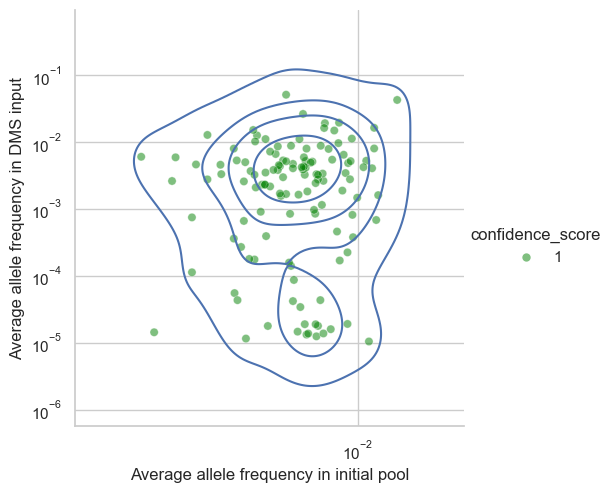

In [35]:
cscore_colors = ['green','orange','red']

fig = sns.relplot(corrdf, x='average_freq_pool', y='average_freq_input',
                  hue='confidence_score', palette=cscore_colors, alpha=.5
                 )
sns.kdeplot(corrdf,x='average_freq_pool', y='average_freq_input',
            levels=5, log_scale=True)
fig.set(xscale='log', yscale='log',
        xlabel='Average allele frequency in initial pool',
        ylabel='Average allele frequency in DMS input'
       )

/tmp/ipykernel_26411/3711620569.py:20: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.kdeplot(corrdf,x='average_freq_pool', y='average_freq_input',
/tmp/ipykernel_26411/3711620569.py:20: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(corrdf,x='average_freq_pool', y='average_freq_input',


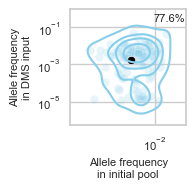

In [36]:
Nham_aa_colors = ['black', 'skyblue', 'pink']
sns.set(rc = {'figure.figsize':(1.5,1.5),
              'font.size':8,
              'legend.title_fontsize':8, 'legend.fontsize':8,
              'axes.labelsize':8,'axes.titlesize':8,
              'xtick.labelsize':8, 'ytick.labelsize':8,
              'xtick.major.pad':1, 'ytick.major.pad':1,
             },
       style='whitegrid')


fig = sns.scatterplot(corrdf[corrdf.Nham_aa == 1],
                      x='average_freq_pool', y='average_freq_input',
                      color=Nham_aa_colors[1], alpha=.2, legend=False
                     )
sns.scatterplot(corrdf[corrdf.Nham_aa == 0],
                x='average_freq_pool', y='average_freq_input',
                color=Nham_aa_colors[0], legend=False
               )
sns.kdeplot(corrdf,x='average_freq_pool', y='average_freq_input',
            hue='Nham_aa', palette=Nham_aa_colors, common_norm=False,
            levels=5, log_scale=True,legend=False)
fig.set(xscale='log', yscale='log',
        xlabel='Allele frequency\nin initial pool',
        ylabel='Allele frequency\nin DMS input'
       )
both_perc = ratios.loc[ratios.Location == 'both', 'aa_seq'].values[0] / unique_aa
fig.annotate(f'{both_perc:.1%}',(.72,.9), xycoords='axes fraction')

plt.savefig(f'{graph_outpath}/{"_".join([strain,locus,pool_type])}_bottleneck.svg', format='svg', dpi=300)